# Flow matching on $\mathbb{R}^n$ and Riemannian manifolds

#### _An EEML 2025 notebook by Oscar Davis._

Welcome to the flow matching notebook, accompanying Joey Bose's talk! Here, we shall present a quick but thorough tour of what flow matching is and how it can be (rather) easily ported to specific geometries (Riemannian manifolds). In the first part, we shall see how to perform usual flow matching, with various samplers, and various couplings allowing for faster training. In the second part, we shall show how to port all of this to the mentioned geometries.

Let's jump right in!

## Setup (libraries, etc.). Just run this part!

Please ignore but run this part; we just need to install a few libraries before being able to start writing flow matching.

In [1]:
%pip install POT
%pip install geoopt
%pip install torchdiffeq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 44.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.1/90.1 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 75.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 57.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 95.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu1

In [2]:
from abc import ABC, abstractmethod


import matplotlib.pyplot as plt
import numpy as np


import torch
from torch import Tensor, nn
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torch.nn import functional as F


from torchdiffeq import odeint
import geoopt
import ot

In [3]:
def generate_smiley_face(points: int):
    def circle_uniform(n_points: int, center: np.ndarray, rad: float = 0.05):
        rad = np.random.uniform(0, rad, n_points)[..., None]
        theta = np.random.uniform(0, 2 * np.pi, n_points)
        points = rad * np.array([np.cos(theta), np.sin(theta)]).T
        return center + points

    def generate_uniform_arc(n_points: int, radius: float, center, angle: float):
        theta = np.linspace(0, angle, n_points)
        rad_pert = np.random.uniform(-0.03, 0.03, n_points)
        x = (radius + rad_pert) * np.cos(theta + 1.25 * np.pi)
        y = (radius + rad_pert) * np.sin(theta + 1.25 * np.pi)
        points = np.column_stack((x, y))
        return points + center[..., None].T

    pts = []
    split_a = points // 3
    split_b = points // 3
    split_c = points - split_a - split_b
    pts += [
        circle_uniform(split_a, np.array([0.4, 0.45]))
    ]
    pts += [
        circle_uniform(split_b, np.array([0.6, 0.45]))
    ]
    pts += [
        generate_uniform_arc(split_c, 0.2, np.array([0.5, 0.3]), np.pi / 2.0)
    ]
    ret = []
    for xs in pts:
        for p in xs:
            ret += [torch.from_numpy(p)]
    fin = torch.stack(ret).view((points, 2)).float()
    fin = fin - fin.mean(dim=0, keepdim=True)
    fin *= 3.0
    return fin


euclidean_smiley_dataset = TensorDataset(
    generate_smiley_face(100_000),
)

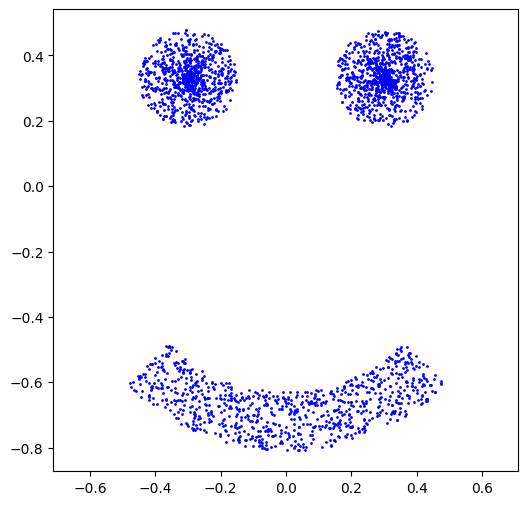

In [4]:
# show dataset
def show_dataset(dataset: Dataset):
    plt.figure(figsize=(6, 6))
    loader = DataLoader(dataset, batch_size=2500, shuffle=True)
    x = next(iter(loader))[0].numpy()
    plt.scatter(x[:, 0], x[:, 1], color="blue", s=1)
    plt.axis('equal')
    plt.show()


show_dataset(euclidean_smiley_dataset)

In [5]:
def visualize_hypersphere(points=None, traj=None):
    fig = plt.figure()
    ax = fig.add_subplot(projection="3d")

    # Make data
    u = torch.linspace(0, 2 * np.pi, 100)
    v = torch.linspace(0, np.pi, 100)
    x = torch.outer(torch.cos(u), torch.sin(v))
    y = torch.outer(torch.sin(u), torch.sin(v))
    z = torch.outer(torch.ones(u.size()), torch.cos(v))

    # Plot the surface
    ax.plot_surface(x, y, z, cmap="Greys_r", zorder=1, alpha=0.3)

    if points is not None:
        ax.scatter(points[:, 0], points[:, 1], points[:, 2], c="r", marker="o", s=20, zorder=2)
    if traj is not None:
        ax.scatter(traj[:, 0], traj[:, 1], traj[:, 2], color="blue", marker="o")

    # Set an equal aspect ratio
    ax.set_aspect("auto")
    # set z axis limit
    ax.set_zlim(-1, 1)
    # set x axis limit
    ax.set_xlim(-1, 1)
    # set y axis limit
    ax.set_ylim(-1, 1)

    plt.show()

In [6]:
def rotate(points, axis, angle):
    axis = axis / axis.norm()  # normalize axis
    ux, uy, uz = axis
    cos = torch.cos(angle)
    sin = torch.sin(angle)
    one_minus_cos = 1 - cos

    R = torch.tensor([
        [cos + ux**2 * one_minus_cos,
         ux*uy*one_minus_cos - uz*sin,
         ux*uz*one_minus_cos + uy*sin],

        [uy*ux*one_minus_cos + uz*sin,
         cos + uy**2 * one_minus_cos,
         uy*uz*one_minus_cos - ux*sin],

        [uz*ux*one_minus_cos - uy*sin,
         uz*uy*one_minus_cos + ux*sin,
         cos + uz**2 * one_minus_cos]
    ], dtype=points.dtype, device=points.device)

    return points @ R.T  # shape (N, 3)


def generate_sphere_smiley(points: int):
    def circle_uniform(n_points: int, center: np.ndarray, rad: float = 0.05):
        rad = np.random.uniform(0, rad, n_points)[..., None]
        theta = np.random.uniform(0, 2 * np.pi, n_points)
        points = rad * np.array([np.cos(theta), np.sin(theta)]).T
        return center + points

    def generate_uniform_arc(n_points: int, radius: float, center, angle: float):
        theta = np.linspace(0, angle, n_points)
        rad_pert = np.random.uniform(-0.03, 0.03, n_points)
        x = (radius + rad_pert) * np.cos(theta + 1.25 * np.pi)
        y = (radius + rad_pert) * np.sin(theta + 1.25 * np.pi)
        points = np.column_stack((x, y))
        return points + center[..., None].T

    pts = []
    split_a = points // 3
    split_b = points // 3
    split_c = points - split_a - split_b
    pts += [
        circle_uniform(split_a, np.array([0.4, 0.45]))
    ]
    pts += [
        circle_uniform(split_b, np.array([0.6, 0.45]))
    ]
    pts += [
        generate_uniform_arc(split_c, 0.2, np.array([0.5, 0.3]), np.pi / 2.0)
    ]
    ret = []
    for xs in pts:
        for p in xs:
            ret += [torch.from_numpy(p)]
    fin = torch.stack(ret).view((points, 2)).float()
    fin = fin - fin.mean(dim=0, keepdim=True)
    fin *= 3.7

    pad = torch.sqrt(1.0 - torch.sum(fin ** 2, dim=1, keepdim=True))  # compute the z coordinate
    fin = torch.cat((pad, fin[:, 0:1], fin[:, 1:]), dim=1)  # add a third
    # project on sphere
    fin = fin / torch.norm(fin, dim=1, keepdim=True)
    # rotate all points

    return rotate(fin, axis=torch.tensor([-0.3, 0, 1.]), angle=torch.tensor(np.pi / 1.5))  # rotate around y axis by 90 degrees


sphere_smiley_dataset = TensorDataset(
    generate_sphere_smiley(100_000),
)

<Figure size 600x600 with 0 Axes>

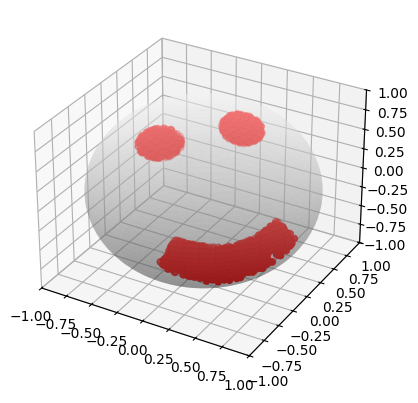

In [7]:
def show_dataset_sphere(dataset: Dataset):
    plt.figure(figsize=(6, 6))
    loader = DataLoader(dataset, batch_size=2500, shuffle=True)
    x = next(iter(loader))[0].numpy()
    visualize_hypersphere(points=x)
    plt.show()


show_dataset_sphere(sphere_smiley_dataset)

In [8]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, endpoint=False):
        super(MLP, self).__init__()
        layers = []
        input_size += 1  # time
        for i in range(num_layers):
            if i == 0:
                layers.append(nn.Linear(input_size, hidden_size))
            elif i == num_layers - 1:
                layers.append(nn.Linear(hidden_size, output_size))
            else:
                layers.append(nn.Linear(hidden_size, hidden_size))
            if i < num_layers - 1:
                layers.append(nn.SiLU())
        self.layers = nn.Sequential(*layers)
        self.endpoint = endpoint

    def forward(self, x, t):
        orig_x = x
        if t.dim() < x.dim():
            t = t.unsqueeze(-1)
        x = torch.cat([t, x], dim=-1)
        if self.endpoint:
            return self.layers(x) * (1.0 - t) + t * orig_x
            # return t * orig_x + (1.0 - t) * self.layers(x)
        return (1.0 - t) * self.layers(x)

In [9]:
def print_parameter_count(model: nn.Module):
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Total number of parameters: {total_params:,}")


def show_samples(samples: Tensor):
    plt.figure(figsize=(6, 6))
    plt.scatter(samples[:, 0].numpy(), samples[:, 1].numpy(), color="gray", s=1, alpha=0.3)
    plt.axis('equal')
    plt.show()

In [10]:
class OTSampler:
    """
    Based on:
    `https://github.com/DreamFold/FoldFlow/blob/main/FoldFlow/utils/optimal_transport.py`.
    """

    def __init__(
        self,
        normalize_cost: bool = False,
    ):
        self.ot_fn = ot.emd
        self.normalize_cost = normalize_cost

    @torch.no_grad()
    def get_map(self, x0: Tensor, x1: Tensor, dists: Tensor) -> Tensor:
        """
        Compute the OT plan between a source and a target minibatch.
        """
        a, b = (
            torch.full((x0.shape[0],), 1.0 / x0.shape[0], device=x1.device),
            torch.full((x1.shape[0],), 1.0 / x1.shape[0], device=x1.device),
        )
        m = dists
        if self.normalize_cost:
            m = m / m.max()  # should not be normalized when using minibatches
        p = self.ot_fn(a, b, m)
        return p

    def sample_map(self, pi: Tensor, batch_size: int):
        r"""
        Draw source and target samples from `pi`, $(x,z) \sim \pi$.
        """
        p = pi.flatten()
        p = p / p.sum()
        # choices = np.random.choice(pi.shape[0] * pi.shape[1], p=p, size=batch_size)
        # return np.divmod(choices, pi.shape[1])
        choices = torch.multinomial(
            p, num_samples=batch_size, replacement=True,
        ).long()
        return torch.floor_divide(choices, pi.shape[1]), torch.remainder(choices, pi.shape[1])

    def sample_plan(self, x0: Tensor, x1: Tensor, dists: Tensor) -> tuple[Tensor, Tensor]:
        r"""
        Compute the OT plan $\pi$ (wrt squared Euclidean cost) between a source and a target
        minibatch and draw source and target samples from `pi` $(x,z) \sim \pi$
        """
        pi = self.get_map(x0, x1, dists)
        i, j = self.sample_map(pi, x0.shape[0])
        return x0[i], x1[j]

## Flow matching in $\mathbb{R^n}$

### Simple recap of the algorithm
We are interested in generating a target distribution, $p_1$ (from which, as usual, we have only samples). Flow matching addresses this issue by attempting to find a vector field, $u$, which pushes a prior distribution, $p_0$, to $p_1$. That is to say, if we let $\phi:\mathbb{R}^n\times \mathbb{R}\to \mathbb{R}^n$ be such that
$$
\forall x \in \mathbb{R}^n,t \in [0,1], \qquad \frac{\mathrm{d}}{\mathrm{d}t}\phi(x, t) = u(\phi(x, t), t),\text{ with } \phi(x, 0) = x,
$$
then we want the change of variables induced by $\phi_1$ to satisfy:
$$
\forall x \in \mathbb{R}^n,\qquad p_0(\phi^{-1}(x, 1))\lvert\mathrm{det} J_{\phi_1}^{-1}(x)\rvert = p_1(x).
$$
Note that the initial condition $\phi(x, 0) = x$ is given so that $\phi(x, 0) \sim p_0$ for $x \sim p_0$, so that we can in turn sample from $p_1$ by sampling $x$ from $p_0$ (chosen to be easy to sample to) and obtain $x_1 = \phi(x, 1)$. Note as well that, since $u$ is given by an ODE on the time interval $[0, 1]$, it defines a probability path (_i.e._, a path on the probability space), $(p_t)_{t\in[0,1]}$, which is also hard to sample from for $t \neq 0, 1$.

In short, we are trying to bring $p_0$ to $p_1$ step by step.

Now, how to find this vector field? A first important observation to make is that, if we know the endpoint, $x_1$, the vector field leading to $x_1$ from any given point, $x_t$, is easy to find! Indeed, it is $u(x_t, t\mid x_1) = \frac{x_1 - x_t}{1 - t}$. Therefore, the "trivial" solution to find such a vector field is to marginalise over all possible target $x_1$'s. Letting
$$
\forall x_t \in \mathbb{R}^n, t\in[0,1],\qquad u(x_t, t) = \int u(x_t,t \mid x_1) \color{red}{\frac{p_t(x_t \mid x_1) p_1(x_1)}{p_t(x_t)}} \mathrm{d}x_1
$$
provides a vector field, $u$, that does push $p_0$ to $p_1$. Note how this is similar to the law of total probability! The final vector field is the "weighted aggregate of all the conditional ones". Indeed, the right part is nothing more than, by Bayes' Theorem,
$$
\color{red}{\frac{p_t(x_t \mid x_1) p_1(x_1)}{p_t(x_t)}} = \color{red}{p_t(x_1\mid x_t)}.
$$

In any case, the integral is intractable, making it unusable for training/sampling, and so _here comes the clever trick_.

The flow matching paper shows that training on the conditional vector field, $u(\cdot, \cdot \mid x_1)$, leads to the same gradients as training on the unconditional one. That is to say,
$$
\nabla_\theta \mathbb{E}_{t, p_t}\lVert v_\theta(x_t, t) - u(x_t, t) \rVert^2_2 = \nabla_\theta\mathbb{E}_{t, p_1, p_t}\lVert v_\theta(x_t, t) - u(x_t, t \mid x_1)\rVert_2^2.
$$
So, *optimising for the intractable vector field is the same as optimising for the conditional and simple to compute vector field.* We can thus train to generate $p_1$ by using the right-hand side objective, which is tractable. :)

#### Summary of the training algorithm
1. Sample $x_0 \sim p_0$, $t \sim [0, 1]$;
2. Get $x_t \gets (1 - t)x_0 + tx_1$;
3. Construct the target _conditional_ vector field, $u(x_t, t \mid x_1) = \frac{x_1 - x_t}{1 - t}$;
4. Calculate the loss: $L(\theta) = \lVert v_\theta(x_t, t) - u(x_t, t\mid x_1)\rVert_2^2$. (Backpropagate, etc.)

#### Sampling algorithm
Finally, to obtain samples from the target distribution, $p_1$, all we need to do is to integrate $v_\theta$ from time $0$ to $1$ from a starting point $x_0 \sim p_0$. We shall see later a little bit lower how to do this in different ways.

### Implementation

Let us now implement what we have been talking about!

#### Training

In [11]:
def euclidean_prior(n: int, d: int) -> Tensor:
    # TODO: implement the prior p_0 for the Euclidean case
    return torch.randn((n,d))
    # Use a standard normal distribution
    # n is the batch size
    # d is the dimension of the data
    ### YOUR CODE HERE
    # raise NotImplementedError()


def sample_random_times(n: int) -> Tensor:
    # TODO: sample random times t_i from the uniform distribution
    # on [0, 1]
    # n is the batch size
    return torch.rand((n,))
    ### YOUR CODE HERE
    # raise NotImplementedError()


def euclidean_conditional_vf(xt: Tensor, x: Tensor, t: Tensor) -> Tensor:
    target_vf = (x - xt)/(1 - t)
    return target_vf
    # TODO implement the conditional vector field
    ### YOUR CODE HERE
    # raise NotImplementedError()


def euclidean_vf_loss(out: Tensor, target: Tensor) -> Tensor:
    # TODO implement the loss function for the vector field
    # out is the output of the neural net
    # target is the target value (conditional vf)
    # return the MSE loss
    return torch.nn.functional.mse_loss(out, target)
    ### YOUR CODE HERE
    # raise NotImplementedError()

Using these, we can now write the basic training function!

In [12]:
def train(
    model: nn.Module,
    epochs: int,
    dataset: Dataset,
    batch_size: int,
    lr: float = 1e-3,
) -> tuple[nn.Module, list[float]]:
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    print_parameter_count(model)
    record_losses = []
    for epoch in range(epochs):
        losses = []
        model.train()
        for x1 in dataloader:  # x1 ~ p_1
            x1 = x1[0]
            optimizer.zero_grad()
            x0 = euclidean_prior(x1.size(0), x1.size(1))  # x0 ~ p_0
            t = sample_random_times(x1.size(0))[..., None]
            xt = (1.0 - t) * x0 + t * x1  # linear interpolation
            y = euclidean_conditional_vf(xt, x1, t)
            y_pred = model(xt, t)
            l = euclidean_vf_loss(y_pred, y)
            l.backward()
            optimizer.step()
            losses += [l.item()]

        # Report loss
        record_losses += [np.mean(losses)]
        print(f"Epoch {epoch+1}/{epochs}, Loss: {record_losses[-1]:.4f}")
    # plot the loss curve
    plt.figure(figsize=(10, 5))
    plt.plot(record_losses, label='Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.legend()
    plt.show()
    return model, record_losses

Let's train the model on our toy dataset!

Total number of parameters: 133,122
Epoch 1/25, Loss: 0.6406
Epoch 2/25, Loss: 0.6127
Epoch 3/25, Loss: 0.5776
Epoch 4/25, Loss: 0.5417
Epoch 5/25, Loss: 0.5281
Epoch 6/25, Loss: 0.5254
Epoch 7/25, Loss: 0.5176
Epoch 8/25, Loss: 0.5074
Epoch 9/25, Loss: 0.5026
Epoch 10/25, Loss: 0.4973
Epoch 11/25, Loss: 0.4893
Epoch 12/25, Loss: 0.4908
Epoch 13/25, Loss: 0.4863
Epoch 14/25, Loss: 0.4904
Epoch 15/25, Loss: 0.4931
Epoch 16/25, Loss: 0.4876
Epoch 17/25, Loss: 0.4871
Epoch 18/25, Loss: 0.4819
Epoch 19/25, Loss: 0.4821
Epoch 20/25, Loss: 0.4839
Epoch 21/25, Loss: 0.4822
Epoch 22/25, Loss: 0.4847
Epoch 23/25, Loss: 0.4837
Epoch 24/25, Loss: 0.4823
Epoch 25/25, Loss: 0.4818


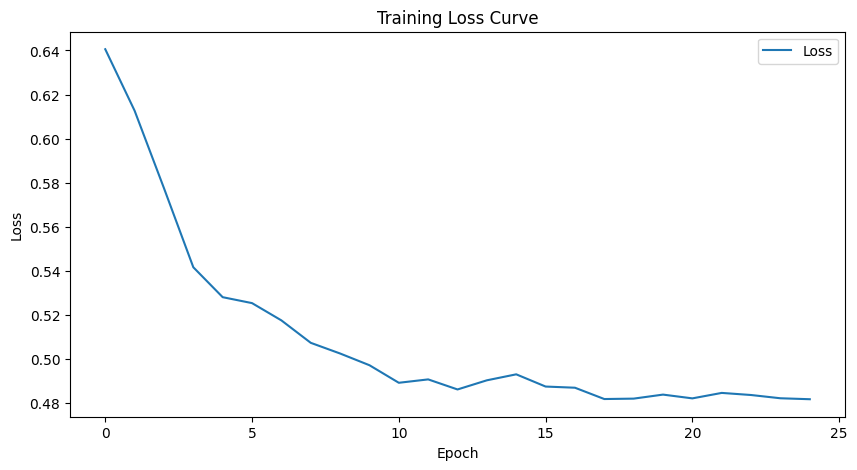

In [13]:
euclidean_model, euclidean_losses = train(
    model=MLP(
        input_size=2,  # 2D data
        hidden_size=256,
        output_size=2,  # output is also 2D
        num_layers=4,
    ),
    epochs=25,
    dataset=euclidean_smiley_dataset,
    batch_size=128,
    lr=5.0 * 1e-4,
)

#### Sampling

As promised, we shall now discuss the implementation of the sampling algorithn. We shall not get into too much detail about ODE solving, but we shall present a few options that we have and that are readily available. Recall that we are aiming to solve the following ODE:
$$
\forall x \in \mathbb{R}^n, t\in[0,1],\qquad\frac{\mathrm{d}}{\mathrm{d}t}\phi(x, t) = u(\phi(x, t), t),\text{ with } \phi(x, 0) = x.
$$

The most naive method is called Euler integration, and it consists in using a simple approximation of a derivative given by its definition. Indeed, we have that
$$
\forall x \in \mathbb{R}^n, t\in (0, 1),\qquad\frac{\mathrm{d}}{\mathrm{d}t}\phi(x, t) := \lim_{\tau\to 0} \frac{\phi(x, t+\tau) - \phi(x, t)}{\tau}.
$$

Therefore, combining both equations, we have that
$$
\lim_{\tau\to 0} \frac{\phi(x, t+\tau) - \phi(x, t)}{\tau} = u(\phi(x, t), t).
$$
If we use the left-hand side as an approximation, for "small enough" $\tau > 0$, we allow ourselves to write:
$$
\frac{\phi(x, t+\tau) - \phi(x, t)}{\tau} \approx u(\phi(x, t), t),
$$
which implies that
$$
\phi(x, t+\tau) \approx \tau u(\phi(x, t), t) + \phi(x, t).
$$
Let us then define $y_t := \phi(x_0, t)$ for $x_0 \sim p_0$. Since $y_0 = \phi(x_0, 0) = x_0$, we can thus just follow the recurrence relation $y_{t + \tau} = y_t + \tau u(y_t, t)$ to reach $y_1 \sim p_1$, after having sampled $x_0 \sim p_0$. Observe that as $\tau$ tends to zero, we get closer to the actual solution of the ODE, but which costs therefore more integration steps, introducing a tradeoff!

The final algorithm is, for $N \in \mathbb{N}^\star$ integration steps:
1. Sample $x_0 \sim p$;
2. Repeat $x_{t+1} = x_t + \tau u_\theta(x_t, t)$, until $x_N$ is reached, where $\tau = \frac{1}{N}$;
3. Return $x_N$.

This is a simple integration technique that will be good enough in our scenario, and we shall implement it right away.

In [51]:
@torch.inference_mode()  # turns off gradient computations for faster inference
def euclidean_euler_sampling(
    model: nn.Module,
    n_samples: int = 1000,
    n_steps: int = 100,
    n_data: int = 2,
) -> list[Tensor]:
    # TODO implement the Euler sampling method
    # returning all time steps as a list ([y_t] for varying t).
    # The last element should be the final sample.
    # n_steps is the number of steps to take
    x = torch.randn((n_samples, n_data))
    # tau = 1/n_steps
    ts = torch.linspace(0.0, 1.0, n_steps + 1)
    model.eval()

    y_ts = [x]
    for s, t in zip(ts[:-1], ts[1:]):
      s = s.expand(n_samples, 1)
      t = t.expand(n_samples, 1)
      x = x + (t-s) * model(x, s)
      y_ts.append(x)

    # y_ts = []
    # for i in range(n_steps):
    #   t = torch.ones(n_samples)*(i*tau)
    #   u_t_hat = model(xt, t)
    #   xt = xt + tau * u_t_hat
    #   y_ts.append(xt)

    ### YOUR CODE HERE
    return y_ts
    # raise NotImplementedError()

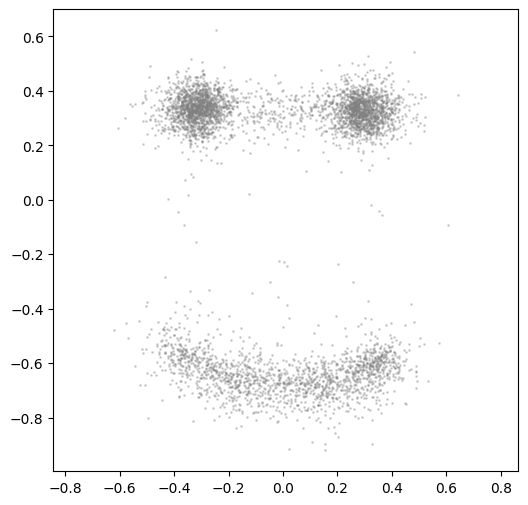

In [52]:
# Sample from the model!
euclidean_samples = euclidean_euler_sampling(
    model=euclidean_model,
    n_samples=5000,
    n_steps=100,
)[-1]


show_samples(euclidean_samples)

Now, while Euler integration is easy, understandable, and works relatively well, there are better, more involved methods to solve ODEs. We shall not go through their mathematical detail together, but we shall showcase how to use these using a library for PyTorch, `torchdiffeq`. To solve an equation of the form
$$
\frac{\mathrm{d}y}{\mathrm{d}t} = f(t, y),\text{ with } y(0) = y_0,
$$
it suffices to call
```python
from torchdiffeq import odeint
odeint(f, y0, t)
```
where `t` are the times at which we want to evaluate the solution to the ODE. (Note the order of the arguments!) For instance, to use Euler integration, we can do the following:

```python
odeint(
    lambda t, y: model(y, t),  # to fix the parameters' order!
    x0,
    torch.tensor([0.0, 1.0]),  # specify start and stop
    method="euler",
    step_size=torch.tensor(0.01),  # to specify the number of integration steps
)
```

Now we can replace the `method` argument by any we would like! A good alternative for better performance (for instance, for sampling images) is `dopri5` (Dormand-Prince of the 5th order). Try to fill in the following function that should use it to solve an ODE.

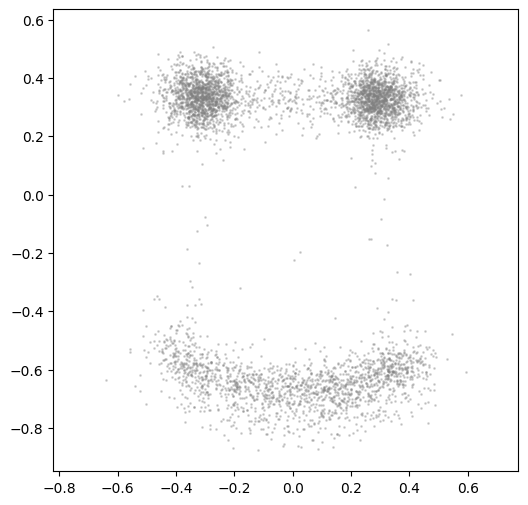

In [57]:
@torch.inference_mode()
def euclidean_dopri5(
    model: nn.Module,
    n_samples: int = 1000,
) -> Tensor:
    # TODO implement the sampling method using the `odeint` function
    # from torchdiffeq
    ### YOUR CODE HERE
    x0 = torch.randn(n_samples, 2)

    def fn(t, y):
      t = t.expand(n_samples, 1)
      return model(y, t)
    out = odeint(fn,
                 x0,
                 torch.Tensor([0.0, 1.0]),
                 method = 'dopri5',
                 atol = 1e-5,
                 rtol = 1e-5)
    return out[-1]

    # raise NotImplementedError()


show_samples(
    euclidean_dopri5(
        model=euclidean_model,
        n_samples=5000,
    ),
)

You are probably already seeing the difference in quality for the generated samples. The accumulation of the errors compounds with time. For instance, see this plot (source: Wikipedia, Runge-Kutta method):

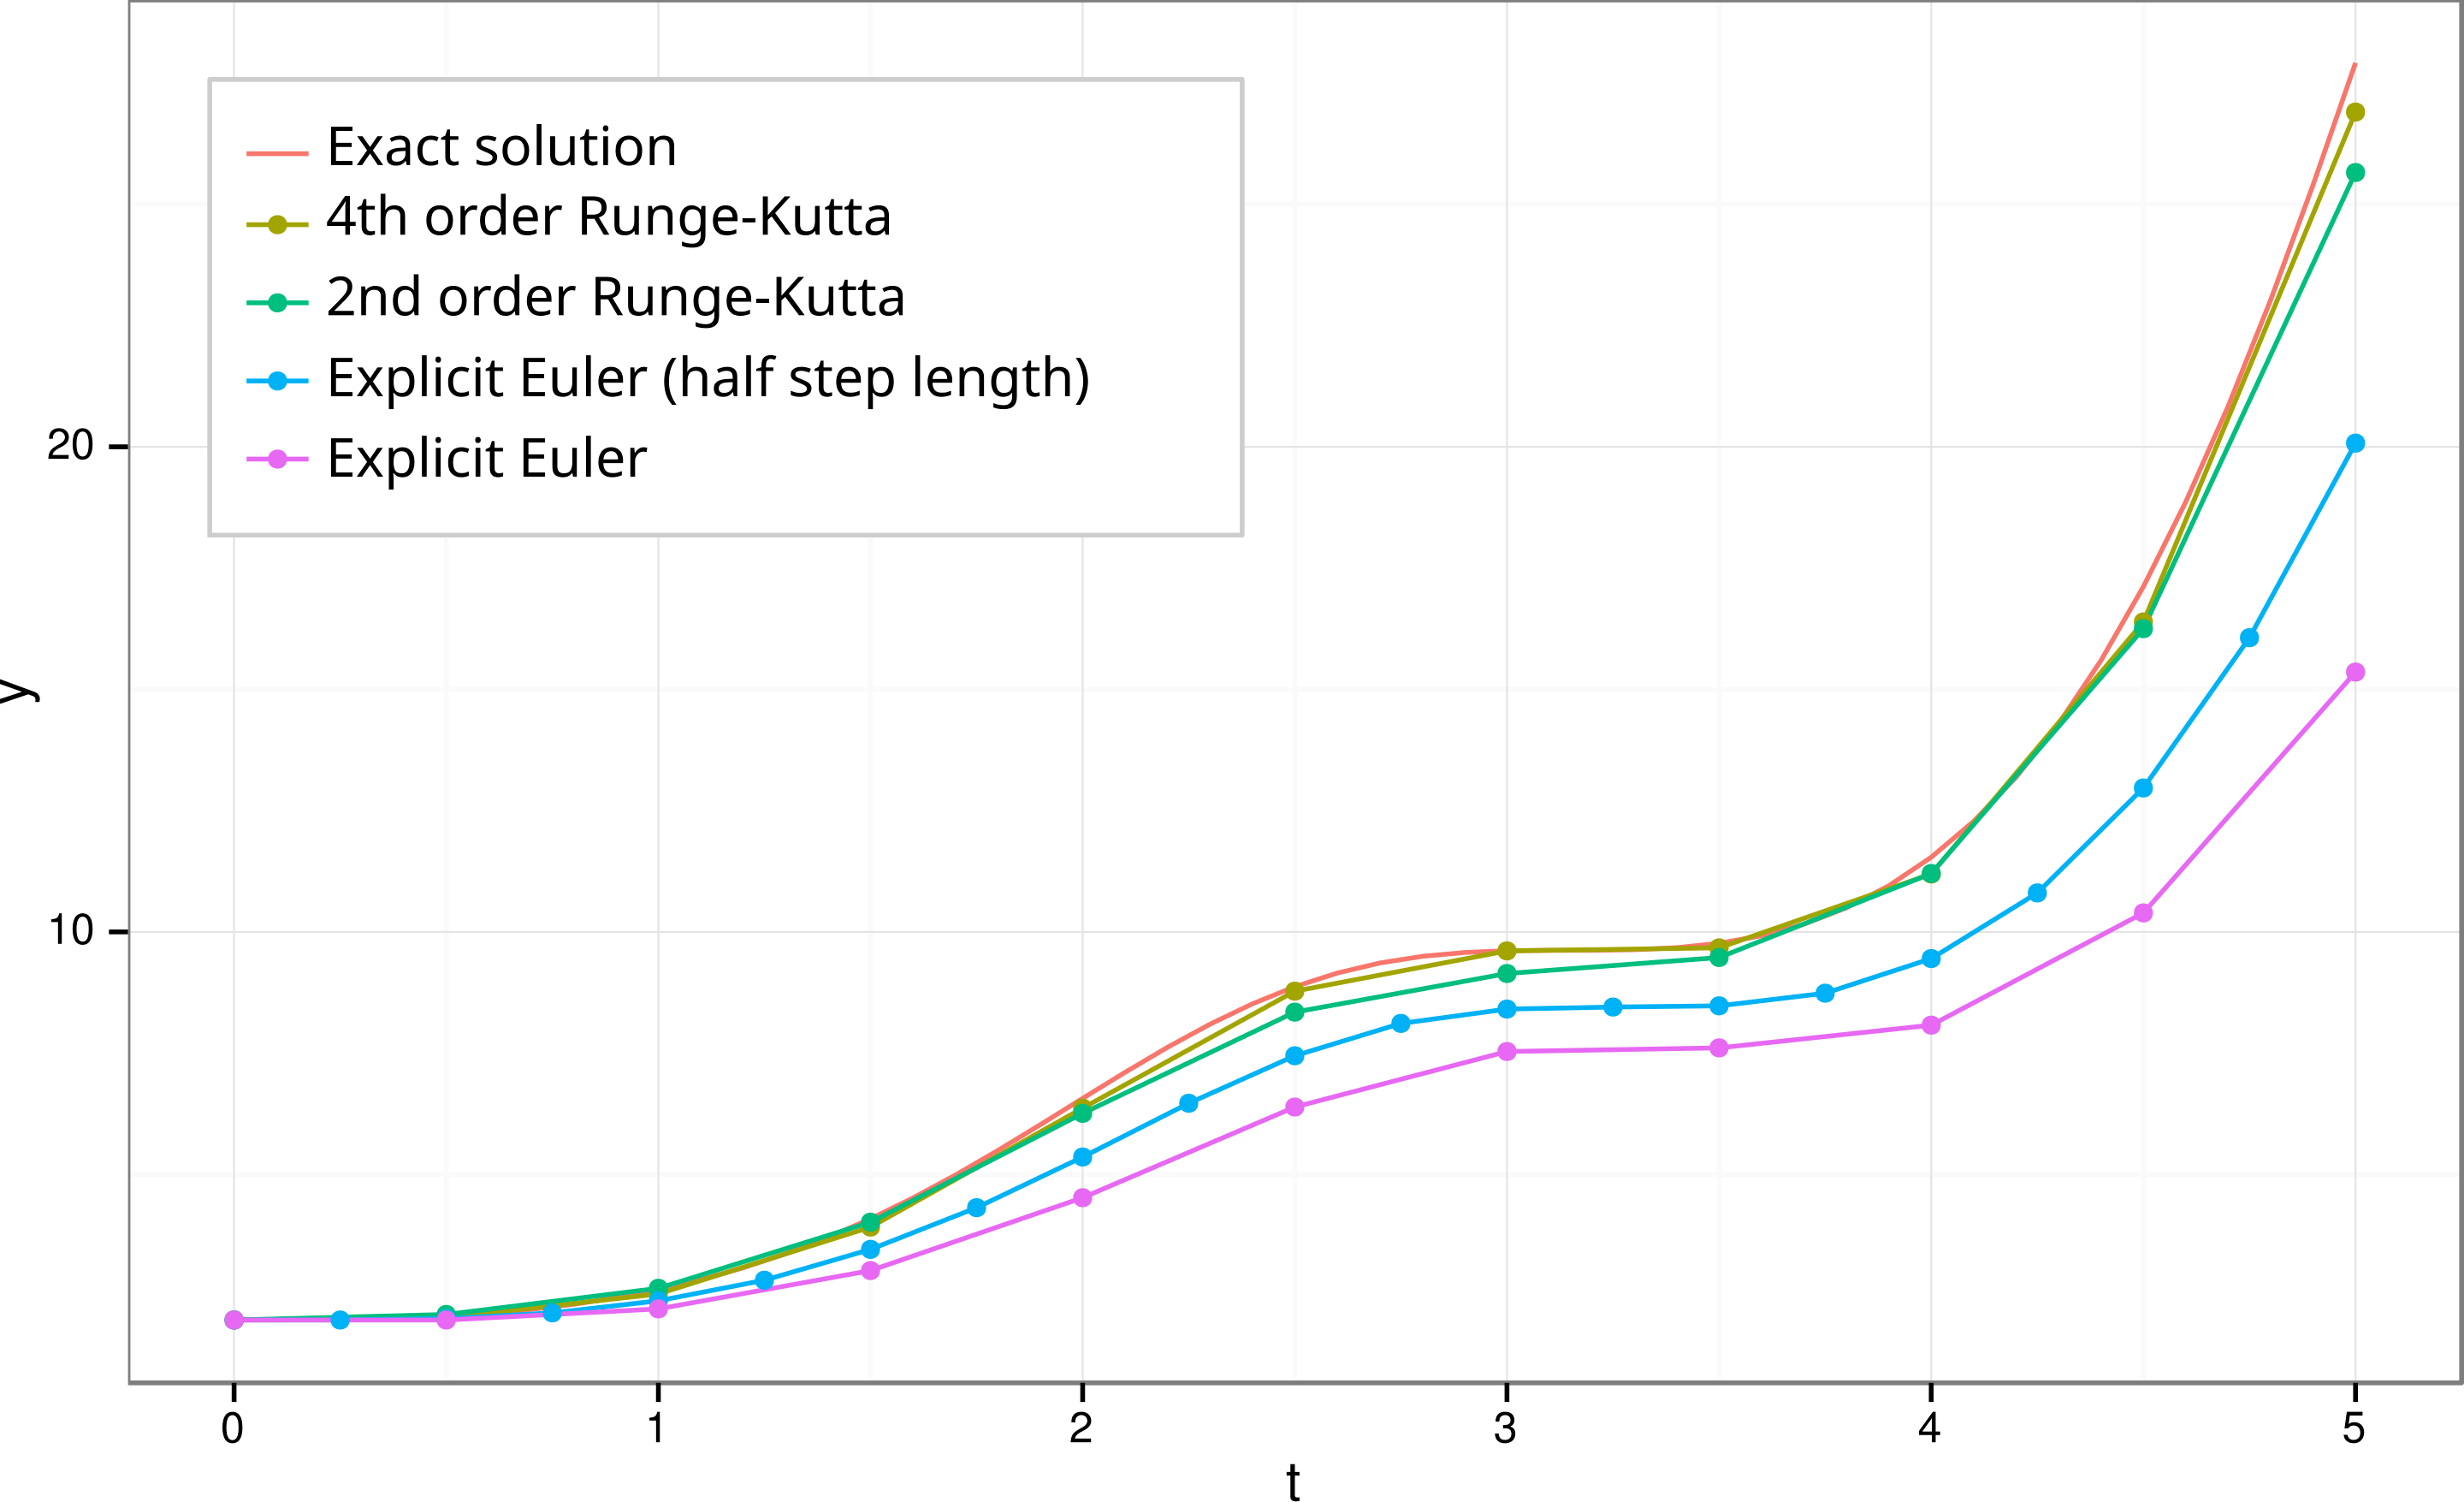

### Extensions

To deepen a bit our understanding of flow matching, let us add two different extensions!

#### Extension \#1: end-point reparameterisation

A trick that is commonly used to train flow matching models is to train to predict the endpoint of the flow, instead of predicting the vector field itself. This is equivalent, but has been found to have better performance in some cases. All there is to change is that the model should now regress on the endpoint, and the integration should then retrieve the conditional vector field from the predicted endpoint.

Can you make those _simple_ change to the code from before to include this trick?

In [60]:
def train_endpoint(
    model: nn.Module,
    epochs: int,
    dataset: Dataset,
    batch_size: int,
    lr: float = 1e-3,
) -> tuple[nn.Module, list[float]]:
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    print_parameter_count(model)
    record_losses = []
    for epoch in range(epochs):
        losses = []
        model.train()
        for x1 in dataloader:  # x1 ~ p_1
            x1 = x1[0]
            optimizer.zero_grad()
            x0 = euclidean_prior(x1.size(0), x1.size(1))  # x0 ~ p_0
            t = sample_random_times(x1.size(0))[..., None]
            xt = (1.0 - t) * x0 + t * x1  # linear interpolation
            y_pred = model(xt, t)
            ### YOUR CODE HERE
            l = F.mse_loss(y_pred, x1) # NOTE: regressing on x1 only (instead of xt)
            l.backward()
            optimizer.step()
            losses += [l.item()]

        # Report loss
        record_losses += [np.mean(losses)]
        print(f"Epoch {epoch+1}/{epochs}, Loss: {record_losses[-1]:.4f}")
    # plot the loss curve
    plt.figure(figsize=(10, 5))
    plt.plot(record_losses, label='Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.legend()
    plt.show()
    return model, record_losses

Total number of parameters: 133,122
Epoch 1/25, Loss: 0.1074
Epoch 2/25, Loss: 0.1063
Epoch 3/25, Loss: 0.1041
Epoch 4/25, Loss: 0.1033
Epoch 5/25, Loss: 0.1024
Epoch 6/25, Loss: 0.1024
Epoch 7/25, Loss: 0.1022
Epoch 8/25, Loss: 0.1018
Epoch 9/25, Loss: 0.1023
Epoch 10/25, Loss: 0.1018
Epoch 11/25, Loss: 0.1020
Epoch 12/25, Loss: 0.1020
Epoch 13/25, Loss: 0.1016
Epoch 14/25, Loss: 0.1018
Epoch 15/25, Loss: 0.1013
Epoch 16/25, Loss: 0.1020
Epoch 17/25, Loss: 0.1016
Epoch 18/25, Loss: 0.1013
Epoch 19/25, Loss: 0.1018
Epoch 20/25, Loss: 0.1018
Epoch 21/25, Loss: 0.1019
Epoch 22/25, Loss: 0.1017
Epoch 23/25, Loss: 0.1021
Epoch 24/25, Loss: 0.1015
Epoch 25/25, Loss: 0.1014


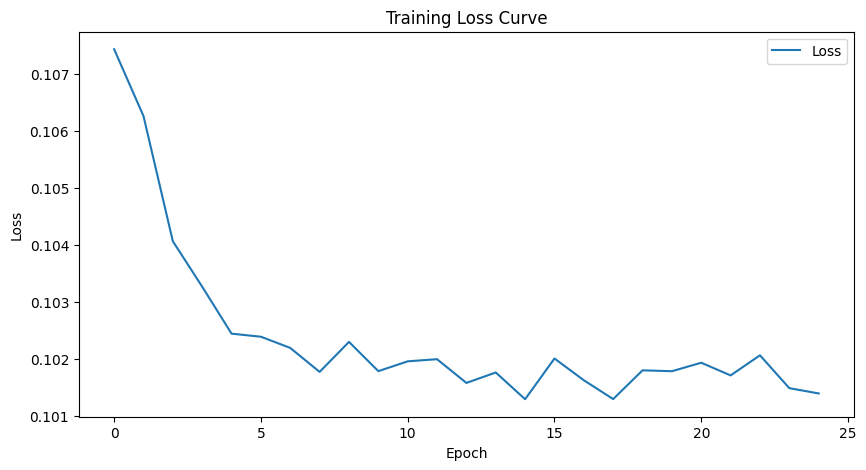

In [61]:
endpoint_euclidean_model, _ = train_endpoint(
    model=MLP(
        input_size=2,  # 2D data
        hidden_size=256,
        output_size=2,  # output is also 2D
        num_layers=4,
        endpoint=True,  # use the endpoint model
    ),
    epochs=25,
    dataset=euclidean_smiley_dataset,
    batch_size=128,
    lr=1e-3,
)

#### Endpoint sampling

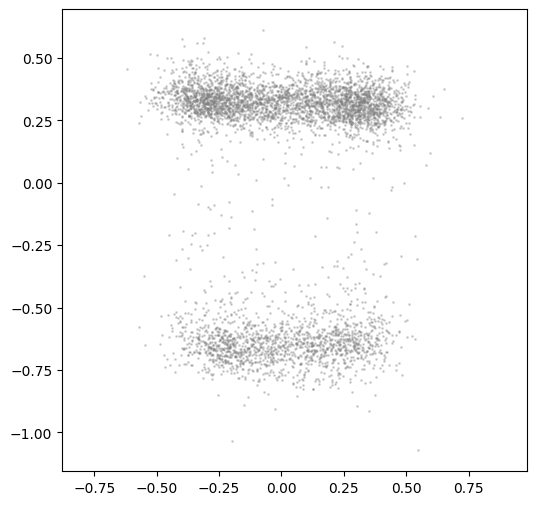

In [64]:
@torch.inference_mode()  # turns off gradient computations for faster inference
def euclidean_euler_endpoint_sampling(
    model: nn.Module,
    n_samples: int = 1000,
    n_steps: int = 100,
) -> list[Tensor]:
    # TODO implement the Euler sampling method
    # returning all time steps as a list ([y_t] for varying t).
    # The last element should be the final sample.
    # n_steps is the number of steps to take
    model.eval()
    ### YOUR CODE HERE
    x = torch.randn((n_samples, 2))
    # tau = 1/n_steps
    ts = torch.linspace(0.0, 1.0, n_steps + 1)
    model.eval()

    y_ts = [x]
    for s, t in zip(ts[:-1], ts[1:]):
      s = s.expand(n_samples, 1)
      t = t.expand(n_samples, 1)
      xt = model(x, s) # Now model is predicting xt_hat instead of ut_hat
      vf = (xt - x) / (1.0 - s) # Here we get ut_hat out of xt_hat
      x = x + (t-s) * vf
      y_ts.append(x)

    # y_ts = []
    # for i in range(n_steps):
    #   t = torch.ones(n_samples)*(i*tau)
    #   u_t_hat = model(xt, t)
    #   xt = xt + tau * u_t_hat
    #   y_ts.append(xt)

    ### YOUR CODE HERE
    return y_ts
    # raise NotImplementedError()


show_samples(
    euclidean_euler_endpoint_sampling(
        model=endpoint_euclidean_model,
        n_samples=5000,
        n_steps=200,
    )[-1]
)

#### Extension \#2: Optimal transport coupling

A less trivial extension is that of optimal transport coupling between the data and the noise points. Indeed, so far, our prior, $x_0$, and data points, $x_1$, are sampled independently, which we typically write as $\pi(x_0, x_1) = p_0(x_0)p_1(x_1)$. However, this procedure has inherently quite high variance, as the same data points can be coupled with points different prior points all over the plane. Moreover, between batched tensors $x_0$ and $x_1$ of noise and data, respectively, there can be _crossings_ between the assignments; that is to say, it is highly likely that, for some $i \neq j$, the line between $x_0[i]$ and $x_1[i]$, and that between $x_0[j]$ and $x_1[j]$ may intersect. (We denote by $x[i]$ the $i$-th element of the tensor $x$.)

For instance, suppose our prior is a Gaussian and our target distribution too:

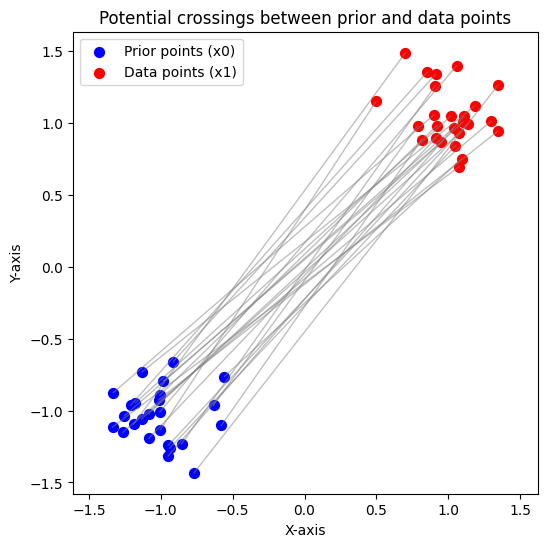

In [65]:
def show_potential_crossings():
    n = 25
    # prior points (sampled independently from x1)
    x0 = torch.randn(n, 2) * 0.2 - torch.tensor([1.0, 1.0])

    # data points (sampled independently from x0)
    x1 = torch.randn(n, 2) * 0.2 + torch.tensor([1.0, 1.0])

    plt.figure(figsize=(6, 6))
    plt.scatter(x0[:, 0].numpy(), x0[:, 1].numpy(), color="blue", s=50, label="Prior points (x0)")
    plt.scatter(x1[:, 0].numpy(), x1[:, 1].numpy(), color="red", s=50, label="Data points (x1)")
    plt.plot(
        [x0[:, 0], x1[:, 0]], [x0[:, 1], x1[:, 1]], color="gray", alpha=0.5, linewidth=1
    )
    plt.title("Potential crossings between prior and data points")
    plt.xlabel("X-axis")
    plt.ylabel("Y-axis")
    plt.axis("equal")
    plt.legend()
    plt.show()


show_potential_crossings()

This is a problem, since an ODE does not have such crossings, because it is deterministic and invertible, and therefore cannot lead to such assignments. So, we are effectively teaching something "a bit wrong" to our model.

An easy way to solve this is by approximating the optimal transport (OT) map between $p_0$ and $p_1$. The goal of OT --- which is a rich theory in which we cannot delve too much into --- is to minimise the transport cost (typically defined using some notion of distance) between some source and target distributions. Formally, we are looking for a map between distributions $\mu$ and $\nu$, which is defined as the following minimiser (formally an $\inf$):
$$
T^\star = \mathrm{argmin}_{T}\int c(x, T(x)) \mathrm{d}x\text{, where } T_\# \mu = \nu.
$$
$T_\#$ denotes the pushforward (that is to say, the change of variables: the $T$'s considered must transform $\mu$ into $\nu$), and $c$ is some cost function, for instance $c:(x, y)\mapsto \lVert x - y \rVert$. This is one of the simplest formulations of the problem, as we ignore the typical Kantorovich relaxation, which allows this minimisation to be probabilistic; but it allows us to gain some intuition on the problem.

By its optimality properties, we know that the OT plan offers us a coupling that does not contain any crossings. Let us visualise the difference between those assignments. All we need to compute is our notion of cost (here, just the pairwise Euclidean distances), and the optimal transport in computed using another package (`POT`):

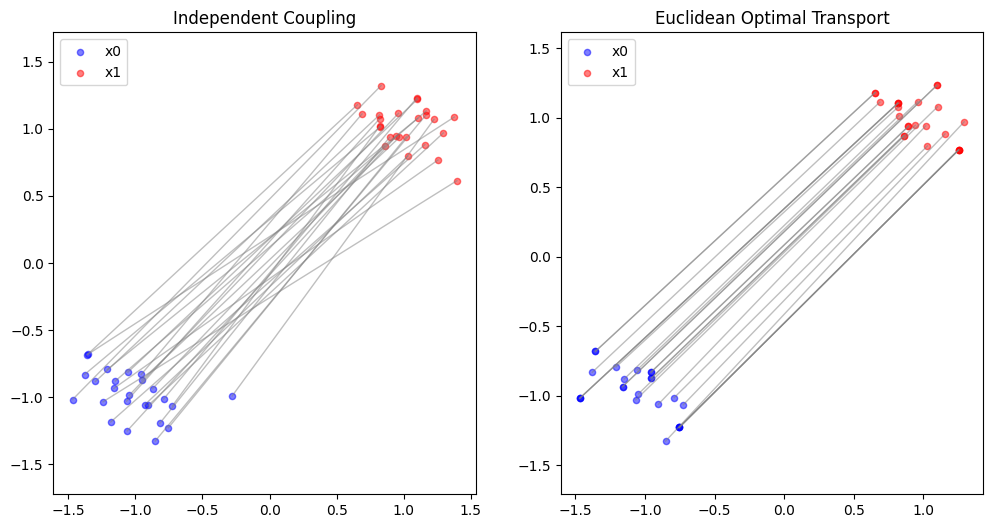

In [66]:
def show_euclidean_ot():
    # instantiate the included OT sampler (please ignore the implementation details)
    sampler = OTSampler(
        normalize_cost=False,
    )
    n = 25
    # prior points (sampled independently from x1)
    x0 = torch.randn(n, 2) * 0.2 - torch.tensor([1.0, 1.0])

    # data points (sampled independently from x0)
    x1 = torch.randn(n, 2) * 0.2 + torch.tensor([1.0, 1.0])

    # Calculation of cost: pairwise (Euclidean) distances
    dists = torch.cdist(x0, x1, p=2)
    # OT plan resampled
    x0_sampled, x1_sampled = sampler.sample_plan(x0, x1, dists)


    # Plotting (ignore)
    fig, axs = plt.subplots(figsize=(12, 6), nrows=1, ncols=2)
    # independent coupling
    axs[0].scatter(x0[:, 0].numpy(), x0[:, 1].numpy(), color="blue", s=20, alpha=0.5, label="x0")
    axs[0].scatter(x1[:, 0].numpy(), x1[:, 1].numpy(), color="red", s=20, alpha=0.5, label="x1")
    axs[0].plot(
        [x0[:, 0], x1[:, 0]], [x0[:, 1], x1[:, 1]], color="gray", alpha=0.5, linewidth=1
    )
    axs[0].set_title("Independent Coupling")
    axs[0].axis("equal")
    axs[0].legend(loc="upper left")

    # ot coupling
    axs[1].scatter(x0_sampled[:, 0].numpy(), x0_sampled[:, 1].numpy(), color="blue", s=20, alpha=0.5, label="x0")
    axs[1].scatter(x1_sampled[:, 0].numpy(), x1_sampled[:, 1].numpy(), color="red", s=20, alpha=0.5, label="x1")
    axs[1].plot(
        [x0_sampled[:, 0], x1_sampled[:, 0]], [x0_sampled[:, 1], x1_sampled[:, 1]], color="gray", alpha=0.5, linewidth=1
    )
    axs[1].set_title("Euclidean Optimal Transport")
    axs[1].axis("equal")
    axs[1].legend(loc="upper left")
    plt.show()


show_euclidean_ot()

No more crossings, as promised! ;)

Can you incroporate this into our training procedure? Can you plot the losses of the non-OT model alongside this one? Do you notice anything?

Total number of parameters: 133,122
Epoch 1/25, Loss: 0.1557
Epoch 2/25, Loss: 0.0752
Epoch 3/25, Loss: 0.0537
Epoch 4/25, Loss: 0.0476
Epoch 5/25, Loss: 0.0450
Epoch 6/25, Loss: 0.0433
Epoch 7/25, Loss: 0.0419
Epoch 8/25, Loss: 0.0419
Epoch 9/25, Loss: 0.0407
Epoch 10/25, Loss: 0.0421
Epoch 11/25, Loss: 0.0404
Epoch 12/25, Loss: 0.0409
Epoch 13/25, Loss: 0.0389
Epoch 14/25, Loss: 0.0395
Epoch 15/25, Loss: 0.0394
Epoch 16/25, Loss: 0.0388
Epoch 17/25, Loss: 0.0400
Epoch 18/25, Loss: 0.0378
Epoch 19/25, Loss: 0.0400
Epoch 20/25, Loss: 0.0387
Epoch 21/25, Loss: 0.0382
Epoch 22/25, Loss: 0.0385
Epoch 23/25, Loss: 0.0383
Epoch 24/25, Loss: 0.0380
Epoch 25/25, Loss: 0.0371


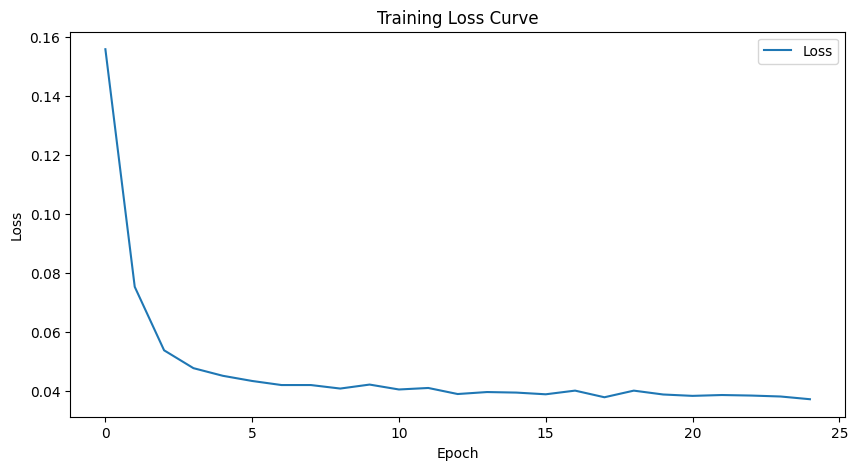

In [67]:
def train_euclidean_ot(
    model: nn.Module,
    epochs: int,
    dataset: Dataset,
    batch_size: int,
    lr: float = 1e-3,
) -> tuple[nn.Module, list[float]]:
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    print_parameter_count(model)
    sampler = OTSampler(normalize_cost=False)
    record_losses = []
    for epoch in range(epochs):
        losses = []
        model.train()
        for x1 in dataloader:  # x1 ~ p_1
            x1 = x1[0]
            optimizer.zero_grad()
            x0 = euclidean_prior(x1.size(0), x1.size(1))  # x0 ~ p_0
            ### YOUR CODE HERE
            dists = torch.cdist(x0, x1)
            x0, x1 = sampler.sample_plan(x0, x1, dists)
            t = sample_random_times(x1.size(0))[..., None]
            xt = (1.0 - t) * x0 + t * x1  # linear interpolation
            y = euclidean_conditional_vf(xt, x1, t)
            y_pred = model(xt, t)
            l = euclidean_vf_loss(y_pred, y)
            l.backward()
            optimizer.step()
            losses += [l.item()]

        # Report loss
        record_losses += [np.mean(losses)]
        print(f"Epoch {epoch+1}/{epochs}, Loss: {record_losses[-1]:.4f}")
    # plot the loss curve
    plt.figure(figsize=(10, 5))
    plt.plot(record_losses, label='Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.legend()
    plt.show()
    return model, record_losses


euclidean_ot_model, euclidean_ot_losses = train_euclidean_ot(
    model=MLP(
        input_size=2,  # 2D data
        hidden_size=256,
        output_size=2,  # output is also 2D
        num_layers=4,
    ),
    epochs=25,
    dataset=euclidean_smiley_dataset,
    batch_size=128,
    lr=5.0 * 1e-4,
)

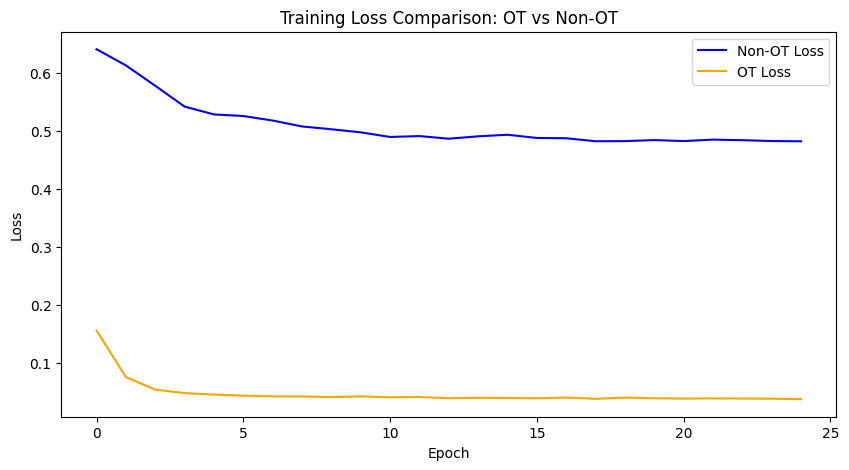

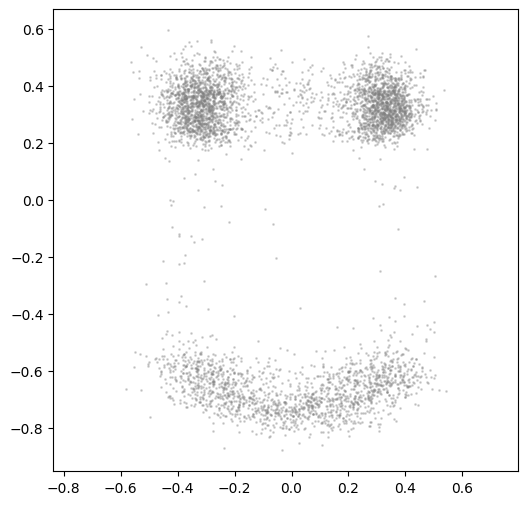

In [68]:
def plot_ot_vs_non_ot():
    plt.figure(figsize=(10, 5))
    plt.plot(euclidean_losses, label='Non-OT Loss', color='blue')
    plt.plot(euclidean_ot_losses, label='OT Loss', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Comparison: OT vs Non-OT')
    plt.legend()
    plt.show()


plot_ot_vs_non_ot()
show_samples(
    euclidean_euler_sampling(
        model=euclidean_ot_model,
        n_samples=5000,
        n_steps=100,
    )[-1]
)

## Flow matching on Riemannian manifolds

Now that we understand flow matching in $\mathbb{R}^n$ pretty well, it is time to port it to Riemannian manifolds! Let us first begin by a small introduction on these. Note that this is, of course, not a course on differential geometry, but hopefully it can serve as a good intuitive introduction for these! :)

### Riemannian manifolds

#### Manifolds

Before considering Riemannian manifolds, let us introduce manifolds themselves. A manifold, ${M}$, is a topological space which "resembles" locally an Euclidean space at each point, $p \in {M}$. Concretely, this means that, at each point $p \in {M}$, there is a _linear local approximation_ of that space. That approximation is called the **tangent space**, and denoted as $T_p{M}$.

The simplest example to illustrate this is that of a function! Consider a differentiable function, $f:\mathbb{R}\to\mathbb{R}$, and consider its graph, ${G} = \{(x,f(x)) \mid x \in \mathbb{R}\}$. At each point $p \in {G}$, the tangent space corresponds to the tangent of the function given by its derivative at $p$, the equation of which is $T_p{M}:y = f(p) + f'(p)(x - p)$. So, _the notion of tangent space generalises our standard notion of derivatives/tangents for functions_.

Another classical example is that of the sphere, for which we provide for here an illustration. (Note that the sphere example can also be related to the "functional" understanding of the tangent space by the implicit function theorem, since it is defined as $\mathbb{S}^2 = \{(x,y,z) \in \mathbb{R}^3 : x^2 + y^2 + z^2 = R\}$ for some $R \in \mathbb{R}_+$.)

![Illustration of the 2-sphere, courtesy of Wikipedia.](attachment:image.png)
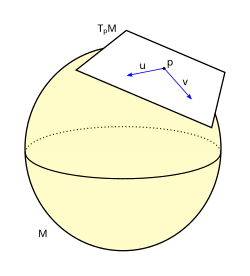

#### Riemannian manifolds in themselves

As you must have noted in the above, the structure of the tangent spaces is _linear_, in a quite classical way. Precisely, these tangent spaces of manifolds form **vector spaces**. These, therefore, satisfy typical properties of vector spaces, such as their stability by linear combination, the fact that they are spanned by $n \in \mathbb{N}^\star$ vectors (where $n$ is the dimensionality of the manifold), etc.

If we now endow this vector space with an inner product, we can create an inner product space. So, with this inner product, which we shall hereinafter call it **the metric**, $g_p: T_p{M} \times T_p{M} \to \mathbb{R}$, we have now that $({M}, g)$ is a **Riemannian manifold**. (Assuming $g_p$ is positive definite and bilinear, and that it varies smoothly with $p$.)

This metric allows to define a notion of length and angles between vectors of tangent spaces! Let $u \in T_p{M}$ for some $p \in {M}$. The former is defined as
$$
\color{yellow}{\lVert u\rVert_g} := \sqrt{\langle u, u \rangle}_g,
$$
where $\langle \cdot, \cdot\rangle_g$ is the metric between $u$ and $v$. (Note that these vectors must belong to the _same_ tangent space for the metric to be properly defined.)

This apparently local property is important as it thereby influences global properties. For instance, the geodesic of a (connected) manifold is the shortest path that connects two points (and its length is therefore the distance). Formally, the geodesic, $\gamma:[0,1]\to{M}$, between $p, q \in {M}$, is defined as
$$
\gamma := \mathrm{argmin}_\gamma \int_0^1 \color{yellow}{\lVert\dot{\gamma}(t)\rVert_g} \mathrm{d}t, \text{ such that } \gamma(0) = p \text{ and } \gamma(1) = q.
$$
Remark that, naturally, $\dot{\gamma}(t) \equiv \frac{\mathrm{d}\gamma(t)}{\mathrm{d}t}$ belongs to $T_{\gamma(t)}{M}$ for all $t \in [0, 1]$.

**Optional exercise**. Could you prove that this definition coincides, in $\mathbb{R}^n$, with our typical notion of distance?

To illustrate the final point about the geodesic, let us explore quickly in code how we can compute the derivative of the geodesic at any given point in time, and what the tangent vector then resembles.

In [69]:
from ipywidgets import interact, FloatSlider


def illustrate_geodesic_derivative(chosen_t):
    # Step 1: Define a function of time that gives us our path, i.e., define a path gamma:[0,1] -> M
    def circle_path(t: Tensor) -> Tensor:
        theta = 2 * np.pi * t
        return torch.stack([torch.cos(theta), torch.sin(theta)], dim=-1)

    # Step 2: Compute the derivative of the path at a specific time t (e.g., t = 0.1)
    xt, ut = torch.func.jvp(circle_path, (torch.tensor([chosen_t]),), (torch.ones(1),))  # compute the derivative at t=0.5
    xt = xt.squeeze()
    ut = ut.squeeze() / ut.norm()  # for visusalisation purposes
    # plot circle
    t = torch.linspace(0, 1, 100)
    circle = circle_path(t)
    plt.figure(figsize=(6, 6))
    plt.plot(circle[:, 0].numpy(), circle[:, 1].numpy(), color="blue", linewidth=2)
    # plot arrow ut at xt
    plt.scatter(xt[0].item(), xt[1].item(), color="red", s=50, label="Point at t=0.1")
    plt.quiver(
        xt[0].item(), xt[1].item(), ut[0].item(), ut[1].item(),
        angles="xy", scale_units="xy", scale=1, color="red", label="Derivative at t=0.1"
    )
    # make plot show everything
    plt.xlim(-1.5, 1.5)
    plt.ylim(-1.5, 1.5)
    plt.title("Circle Path with Start and End Points")
    plt.legend(loc="lower right")
    plt.show()


interact(illustrate_geodesic_derivative, chosen_t=FloatSlider(value=0.1, min=0.0, max=1.0, step=0.01, description="t"))

interactive(children=(FloatSlider(value=0.1, description='t', max=1.0, step=0.01), Output()), _dom_classes=('w…

<function __main__.illustrate_geodesic_derivative(chosen_t)>

As a matter of fact, using automatic differentiation of the geodesic is one of the ways we can compute the conditional vector field in the Riemannian case, which we use to train our vector field! (It is what is done in _Flow Matching on General Geometries._) Indeed, since $\frac{\mathrm{d}}{\mathrm{d}t}\phi(x, t) = u(\phi(x, t), t)$, the conditional vector field is the derivative of the geodesic between $x_0$ and $x_1$ at time $t$.

**Optional exercise**. Verify the last statement for the Euclidean space, knowing that the typical linear interpolation from before, $t\mapsto x_t = (1-t)x_0 + t x_1$, is the geodesic.

### Essential operations on Riemannian manifolds

There are two elementary operations for Riemannian manifolds. Let $p, q \in {M}$, and $v \in T_p{M}$.

1. $\exp$ map: For $v \in T_p{M}$, $\exp_p(v) \in {M}$ is the point on the manifold to which "we arrive after following the direction of the tanget vector $v$". It is the "equivalent of $p+v$ in a plain Euclidean space".

2. $\log$ map: $\log_p(q) \in T_p{M}$ is the tangent vector at point $p$ which "gives the direction towards point $q$ from point $p$". It is the "equivalent of $q - p$ in a plain Euclidean space".

One can verify indeed that $\exp_p(\log_p(q)) = q$, for instance. Note as well that $\exp_p(\mathbf{0}) = p$.

From this knowledge, we can therefore generally express the geodesic (interpolant) between two points on a Riemannian manifold (assuming some mild regularity conditions). We can define it as
$$
\forall t\in[0, 1],\qquad \gamma(t) = \exp_p(t\log_p(q)).
$$

Verify that $\gamma(0) = p$ and $\gamma(1) = q$. :)

**Optional exercise**. What would the geodesic interpolant look like for the Euclidean space, where, for all $p, q \in \mathbb{R}^n$ and $v \in \mathbb{R}^n$ (its tangent space is identified with the whole of $\mathbb{R}^n$), $\exp_p(v) = p + v$, and $\log_p(q) = q - p$?

### Adapting flow matching to Riemannian manifolds

Now that we have a better understanding of Riemannian manifolds, how do we adapt our models so that they can generate data constrained to these?

1. Our data distribution already lies on the manifold; so there is nothing to do there.

2. We need our prior to lie on the manifold. Since we are using flow matching this is simple to fix, as we can pick any prior distribution that has for support the manifold.

3. We need our interpolant to lie on the manifold as well, for which we can use the geodesic interpolant, and the vector field must always lie on the tangent space at the current point; that is to say, $\forall p \in {M}, \forall t \in [0,1], v_\theta(p, t) \in T_p{M}$. To ensure the last part, we can either systemtically project the output of our vector field on the tangent space (when such a projection is available), or we can use the endpoint reparameterisation, and retrieve a vector field using the log map (when it is available).

4. Finally, we need to compute our target vector field. We can either compute it by using automatic differentiation to obtain $\dot{\gamma}(t)$ for the desired $t \in [0, 1]$, and it will thus lay in $T_{\gamma(t)}{M}$; or we can use, as in the Euclidean case, $\log_{x_0}(x_1)$. Nonetheless, the last option would require us to change the tangent space of the vector, as $\log_{x_0}(x_1) \in T_{x_0}{M}$, while $v_\theta(x_t, t) \in T_{x_t}{M}$. Such an operation is possible, and it is called parallel transport, but it is beyond the scope of this notebook, so let us stick to the first option, which we already implemented!

_Remark_: if we are using the endpoint reparameterisation, then we must evaluate the MSE using the distance on the Riemannian manifold instead of the Euclidean one! In the case of the tangent vectors, we should use the metric-induced norm on the tangent space of interest.

#### Implementation of manifolds

Knowing all of this, let us first define some manifold classes. Fill in the Euclidean case by yourself. For the sphere, which will be our example Riemannian manifold, we shall use `geoopt`, a library which will spare us the trouble of having to implement these quite precise operations.

In [70]:
from torch import Tensor


class Manifold(ABC):
    @abstractmethod
    def log(self, p: Tensor, q: Tensor) -> Tensor:
        pass

    @abstractmethod
    def exp(self, p: Tensor, v: Tensor) -> Tensor:
        pass

    @abstractmethod
    def distance(self, p: Tensor, q: Tensor) -> Tensor:
        pass

    @abstractmethod
    def prior(self, n: int, d: int) -> Tensor:
        pass

    @abstractmethod
    def project(self, x: Tensor) -> Tensor:
        # Project the point x onto the manifold
        # This is useful for ensuring that the output of the model lies on the manifold
        pass

    @abstractmethod
    def project_tangent(self, p: Tensor, v: Tensor) -> Tensor:
        # Project the tangent vector v at point p onto the tangent space of the manifold
        # This is useful for ensuring that the output of the model lies in the tangent space
        pass

    @abstractmethod
    def vector_norm(self, p: Tensor, v: Tensor) -> Tensor:
        # Compute the norm of the vector v at point p in the tangent space of the manifold
        pass

    def geodesic_interpolant(self, p: Tensor, q: Tensor, t: Tensor) -> Tensor:
        # TODO
        ### YOUR CODE HERE
        self.exp(p, t * self.log(p, q))
        raise NotImplementedError()


class Euclidean(Manifold):
    def log(self, p: Tensor, q: Tensor) -> Tensor:
        # TODO
        ### YOUR CODE HERE
        # raise NotImplementedError()
        return q - p

    def exp(self, p: Tensor, v: Tensor) -> Tensor:
        # TODO
        ### YOUR CODE HERE
        return p + v
        # raise NotImplementedError()

    def distance(self, p: Tensor, q: Tensor) -> Tensor:
        # TODO
        ### YOUR CODE HERE
        torch.norm(q - p, dim = -1)
        # raise NotImplementedError()

    def prior(self, n: int, d: int) -> Tensor:
        # TODO
        ### YOUR CODE HERE
        torch.randn(n, d)
        # raise NotImplementedError()

    def project(self, x: Tensor) -> Tensor:
        return x

    def project_tangent(self, p: Tensor, v: Tensor) -> Tensor:
        return v

    def vector_norm(self, p: Tensor, v: Tensor) -> Tensor:
        # Compute the norm of the vector v in Euclidean space
        return torch.norm(v, dim=-1)


class Sphere(Manifold):
    def log(self, p: Tensor, q: Tensor) -> Tensor:
        sphere = geoopt.Sphere()
        return sphere.logmap(p, q)

    def exp(self, p: Tensor, v: Tensor) -> Tensor:
        sphere = geoopt.Sphere()
        return sphere.expmap(p, v)

    def distance(self, p: Tensor, q: Tensor) -> Tensor:
        sphere = geoopt.Sphere()
        return sphere.dist(p, q)

    def prior(self, n: int, d: int) -> Tensor:
        sphere = geoopt.Sphere()
        return sphere.random(n, d)

    def project(self, x: Tensor) -> Tensor:
        sphere = geoopt.Sphere()
        return sphere.projx(x)

    def project_tangent(self, p: Tensor, v: Tensor) -> Tensor:
        sphere = geoopt.Sphere()
        return sphere.proju(p, v)

    def vector_norm(self, p: Tensor, v: Tensor) -> Tensor:
        sphere = geoopt.Sphere()
        return sphere.norm(p, v)

#### Implementing Riemannian flow matching

Now, given all these elements, can you edit the few elements in the base code, pasted below, to make flow matching work in the Riemannian setting?

In [71]:
class TangentWrapper(nn.Module):
    def __init__(self, wrapped: nn.Module, manifold: Manifold):
        super().__init__()
        self.wrapped = wrapped
        self.manifold = manifold

    def forward(self, x: Tensor, t: Tensor) -> Tensor:
        return self.manifold.project_tangent(x, self.wrapped(x, t))

In [ ]:
def train_riemannian(
    net: nn.Module,
    epochs: int,
    dataset: Dataset,
    batch_size: int,
    manifold: Manifold,
    lr: float = 1e-3,
) -> nn.Module:
    optimizer = torch.optim.AdamW(net.parameters(), lr=lr)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    # wrap the model with a projection first!
    model = TangentWrapper(net, manifold)
    print_parameter_count(model)
    for epoch in range(epochs):
        losses = []
        model.train()
        for x1 in dataloader:  # x1 ~ p_1
            x1 = x1[0]
            x0 = manifold.prior(x1.size(0), x1.size(1))
            def geodesic(t):
                return manifold.geodesic_interpolant(x0, x1, t)
            optimizer.zero_grad()
            t = sample_random_times(x1.size(0))[..., None]
            xt = manifold.geodesic_interpolant(x0, x1, t)  # linear interpolation

            ### YOUR CODE HERE
            y = torch.func.jvp(..., ..., ...)[1]  # TODO compute the derivative at t
            y_pred = model(xt, t)
            l = manifold.vector_norm(xt, y_pred - y).square()  # use the vector norm on the manifold
            l = l.mean()  # mean over the batch
            l.backward()
            optimizer.step()
            losses += [l.item()]

        # Report loss
        print(f"Epoch {epoch+1}/{epochs}, Loss: {np.mean(losses):.4f}")
    return model

Let us first try this out on the previous smiley dataset!

In [ ]:
riemannian_model = train_riemannian(
    net=MLP(
        input_size=2,  # 2D data
        hidden_size=256,
        output_size=2,  # output is also 2D
        num_layers=4,
    ),
    epochs=25,
    dataset=euclidean_smiley_dataset,
    batch_size=128,
    manifold=Euclidean(),  # use the Euclidean manifold
    lr=5.0 * 1e-4,
)

Similarly, the sampling algorithm can be easily adapted: it suffices to include the exponential map instead of +, and the rest of the algorithm is the same!

In [ ]:
@torch.inference_mode()  # turns off gradient computations for faster inference
def riemannian_euler_sampling(
    model: nn.Module,
    manifold: Manifold,
    n_steps: int = 100,
    n_points: int = 1000,
    n_data: int = 2,
) -> list[Tensor]:
    # TODO implement the Euler sampling method
    # returning all time steps as a list ([y_t] for varying t).
    # The last element should be the final sample.
    # n_steps is the number of steps to take
    model.eval()
    ### YOUR CODE HERE
    raise NotImplementedError()

In [ ]:
show_samples(
    riemannian_euler_sampling(
        model=riemannian_model,
        manifold=Euclidean(),
        n_steps=200,
        n_points=5000,
    )[-1]
)

Now, to check it works for other geometries, let us try out a dataset on the 2-sphere, $\mathbb{S}^2$.

In [ ]:
riemannian_sphere_model = train_riemannian(
    net=MLP(
        input_size=3,  # 3D data
        hidden_size=256,
        output_size=3,  # output is also 3D
        num_layers=4,
    ),
    epochs=25,
    dataset=sphere_smiley_dataset,
    batch_size=128,
    manifold=Sphere(),  # use the Sphere manifold
    lr=5.0 * 1e-4,
)

In [ ]:
visualize_hypersphere(
    points=riemannian_euler_sampling(
        model=riemannian_sphere_model,
        manifold=Sphere(),
        n_steps=300,
        n_points=1000,
        n_data=3,
    )[-1],
)

### Extensions

#### Extension \#1: better samplers

In fact, our better samplers can still be used here, just the same way as before, as long as the projection onto the manifold is still applied (which it already is, thanks to the little `TangentWrapper` wrapper)!

In [ ]:
@torch.inference_mode()
def riemannian_dopri5(
    model: nn.Module,
    manifold: Manifold,
    n_samples: int = 1000,
) -> Tensor:
    # TODO implement the sampling method using the `odeint` function
    # from torchdiffeq
    ### YOUR CODE HERE
    raise NotImplementedError()


visualize_hypersphere(
    points=riemannian_dopri5(
        model=riemannian_sphere_model,
        manifold=Sphere(),
        n_samples=1000,
    ),
)

#### Extension \#2: Optimal transport

Optimal transport is easy to adapt as well! All we need to change is the cost function to now be the distance on our manifold. We also need to implement a way of evaluating all pairwise distances in batches. Unfortunately, the typical implementation does not scale well with the number of samples in the batch (as $O(n^2)$), thus limiting its use. Let us still try to implement it.

**Step 1**. First, complete the following function, which computes all pairwise distances between the elements of `x0` and `x1`.

<details>
<summary>Hint</summary>

Use `repeat` and `repeat_interleave`.
</details>

In [ ]:
def compute_pairwise_distances(
    x0: Tensor,
    x1: Tensor,
    manifold: Manifold,
) -> Tensor:
    """
    Compute pairwise distances between points on a manifold.
    Args:
        x0: Tensor of shape (N, D) representing `N` points on the manifold.
        x1: Tensor of shape (N, D) representing `N` points on the manifold.
    Returns:
        Tensor of shape (N, N) representing pairwise distances.
    """
    # TODO
    ### YOUR CODE HERE
    raise NotImplementedError()


x0_test = torch.randn(10, 3)
x1_test = torch.randn(10, 3)
torch.testing.assert_close(
    compute_pairwise_distances(
        x0=x0_test,
        x1=x1_test,
        manifold=Euclidean(),
    ),
    torch.cdist(
        x0_test,
        x1_test,
        p=2,
    ),
    atol=1e-4,
    rtol=1e-4,
), "Pairwise distances for Euclidean manifold"

Using this function, we can adapt our training procedure to OT Riemannian sampling!

In [ ]:
def train_riemannian_ot(
    net: nn.Module,
    epochs: int,
    dataset: Dataset,
    batch_size: int,
    manifold: Manifold,
    lr: float = 1e-3,
) -> nn.Module:
    optimizer = torch.optim.AdamW(net.parameters(), lr=lr)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    # wrap the model with a projection first!
    model = TangentWrapper(net, manifold)
    print_parameter_count(model)
    sampler = OTSampler(normalize_cost=False)
    for epoch in range(epochs):
        losses = []
        model.train()
        for x1 in dataloader:  # x1 ~ p_1
            x1 = x1[0]
            x0 = manifold.prior(x1.size(0), x1.size(1))
            def geodesic(t):
                return manifold.geodesic_interpolant(x0, x1, t)
            ### YOUR CODE HERE
            optimizer.zero_grad()
            x0, x1 = ...  # TODO
            t = sample_random_times(x1.size(0))[..., None]
            xt = manifold.geodesic_interpolant(x0, x1, t)  # linear interpolation
            y = torch.func.jvp(geodesic, (t,), (torch.ones_like(t),))[1]  # compute the derivative at t
            y_pred = model(xt, t)
            l = manifold.vector_norm(xt, y_pred - y).square()  # use the vector norm on the manifold
            l = l.mean()  # mean over the batch
            l.backward()
            optimizer.step()
            losses += [l.item()]

        # Report loss
        print(f"Epoch {epoch+1}/{epochs}, Loss: {np.mean(losses):.4f}")
    return model

In [ ]:
riemannian_ot_model = train_riemannian_ot(
    net=MLP(
        input_size=3,  # 3D data
        hidden_size=256,
        output_size=3,  # output is also 3D
        num_layers=4,
    ),
    epochs=25,
    dataset=sphere_smiley_dataset,
    batch_size=128,
    manifold=Sphere(),  # use the Sphere manifold
    lr=5.0 * 1e-4,
)

In [ ]:
visualize_hypersphere(
    riemannian_dopri5(
        model=riemannian_ot_model,
        manifold=Sphere(),
        n_samples=1000,
    )
)

#### Extension \#3: endpoint reparameterisation

As promised, we can also use an endpoint reparameterisation of our model. Are you able to implement it here too? Note: here we need, instead of the `TangentWrapper`, a wrapper to project the point on the _manifold_ directly! not a tangent space.

In [ ]:
class ManifoldWrapper(nn.Module):
    def __init__(self, wrapped: nn.Module, manifold: Manifold):
        super().__init__()
        self.wrapped = wrapped
        self.manifold = manifold

    def forward(self, x: Tensor, t: Tensor) -> Tensor:
        # project the output of the model onto the tangent space of the manifold
        ### SOLUTION ###
        return self.manifold.project(self.wrapped(x, t))

In [ ]:
def train_riemannian_endpoint(
    net: nn.Module,
    epochs: int,
    dataset: Dataset,
    batch_size: int,
    manifold: Manifold,
    lr: float = 1e-3,
) -> nn.Module:
    optimizer = torch.optim.AdamW(net.parameters(), lr=lr)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    # wrap the model with a projection first!
    model = ManifoldWrapper(net, manifold)
    print_parameter_count(model)
    for epoch in range(epochs):
        losses = []
        model.train()
        for x1 in dataloader:  # x1 ~ p_1
            x1 = x1[0]
            x0 = manifold.prior(x1.size(0), x1.size(1))
            t = sample_random_times(x1.size(0))[..., None]
            ### YOUR CODE HERE
            optimizer.zero_grad()
            xt = manifold.geodesic_interpolant(x0, x1, t)  # linear interpolation
            y_pred = model(xt, t)
            l = ...  # TODO
            l.backward()
            optimizer.step()
            losses += [l.item()]

        # Report loss
        print(f"Epoch {epoch+1}/{epochs}, Loss: {np.mean(losses):.4f}")
    return model

In [ ]:
riemannian_endpoint_model = train_riemannian_endpoint(
    net=MLP(
        input_size=3,  # 3D data
        hidden_size=256,
        output_size=3,  # output is also 3D
        num_layers=4,
        endpoint=True,
    ),
    epochs=25,
    dataset=sphere_smiley_dataset,
    batch_size=128,
    manifold=Sphere(),  # use the Sphere manifold
    lr=1e-3,
)

Now, adapt the inference code. Remember what we did in the Euclidean case; assume that you can generalise what you did then using $\log$ and $\exp$ maps.

In [ ]:
@torch.inference_mode()  # turns off gradient computations for faster inference
def riemannian_endpoint_euler_sampling(
    model: nn.Module,
    manifold: Manifold,
    n_steps: int = 100,
    n_points: int = 1000,
) -> list[Tensor]:
    # TODO implement the Euler sampling method
    # returning all time steps as a list ([y_t] for varying t).
    # The last element should be the final sample.
    # n_steps is the number of steps to take
    model.eval()
    ### YOUR CODE HERE
    raise NotImplementedError()


In [ ]:
visualize_hypersphere(
    points=riemannian_endpoint_euler_sampling(
        model=riemannian_endpoint_model,
        manifold=Sphere(),
        n_steps=200,
        n_points=1000,
    )[-1]
)